In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Загрузка эмбеддингов
embeddings_path = r"C:\Users\user\Desktop\токс\mol2vec_embeddings_full.csv"
emb_df = pd.read_csv(embeddings_path)

In [36]:
# Проверка данных
print(f"Размер данных: {emb_df.shape}")
print(f"Количество молекул: {len(emb_df)}")
print(f"Размерность эмбеддингов: {emb_df.shape[1] - 1}")  # минус колонка smiles

print("Типы данных:")
print(emb_df.dtypes.value_counts())

Размер данных: (339061, 301)
Количество молекул: 339061
Размерность эмбеддингов: 300
Типы данных:
float64    300
object       1
Name: count, dtype: int64


In [37]:
# Descriptive statistics
embedding_cols = [col for col in emb_df.columns if col.startswith('mol2vec_')]
X_embeddings = emb_df[embedding_cols].values

print(f"Диапазон значений: [{X_embeddings.min():.4f}, {X_embeddings.max():.4f}]")
print(f"Среднее: {X_embeddings.mean():.4f}")
print(f"Стандартное отклонение: {X_embeddings.std():.4f}")
nan_count = np.isnan(X_embeddings).sum()
inf_count = np.isinf(X_embeddings).sum()
print(f"NaN значений: {nan_count}")
# Значения эмбеддингов распределены примерно нормально, среднее около 0, стандартное отклонение около 0.11

Диапазон значений: [-1.0441, 1.1023]
Среднее: -0.0043
Стандартное отклонение: 0.1115
NaN значений: 0


Компонент для 80% дисперсии: 34
Компонент для 90% дисперсии: 68
Компонент для 95% дисперсии: 110
Эффективная размерность: 21 из 300


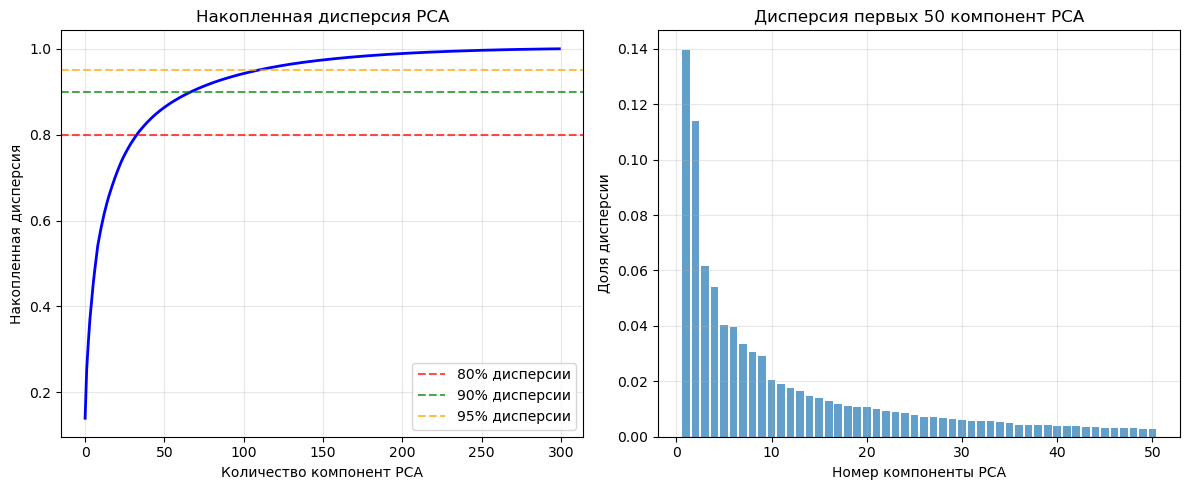

In [38]:
# Анализ эффективной размерности эмбеддингов
# сколько реально независимой информации содержится в 300-мерных эмбеддингах?
# PCA анализ чтобы понять насколько сложные модели нужны 

X_embeddings = emb_df[[col for col in emb_df.columns if col.startswith('mol2vec_')]].values
# Стандартизация для PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_embeddings)
pca_full = PCA()
pca_full.fit(X_scaled)

# Анализ накопленной дисперсии
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Компонент для 80% дисперсии: {n_components_80}")
print(f"Компонент для 90% дисперсии: {n_components_90}") 
print(f"Компонент для 95% дисперсии: {n_components_95}")

# Эффективная размерность (компоненты с >1% дисперсии)
effective_dims = (explained_variance_ratio > 0.01).sum()
print(f"Эффективная размерность: {effective_dims} из 300")

# Визуализация
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cumulative_variance, 'b-', linewidth=2)
plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.7, label='80% дисперсии')
plt.axhline(y=0.9, color='g', linestyle='--', alpha=0.7, label='90% дисперсии')
plt.axhline(y=0.95, color='orange', linestyle='--', alpha=0.7, label='95% дисперсии')
plt.xlabel('Количество компонент PCA')
plt.ylabel('Накопленная дисперсия')
plt.title('Накопленная дисперсия PCA')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(range(1, 51), explained_variance_ratio[:50], alpha=0.7)
plt.xlabel('Номер компоненты PCA')
plt.ylabel('Доля дисперсии')
plt.title('Дисперсия первых 50 компонент PCA')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Дисперсия в 2D PCA: 25.346%
PC1: 13.968%
PC2: 11.378%
Рекомендуемое количество компонент: 110
Низкая сложность ML задачи - можно использовать линейные модели (effective_dims < 50)


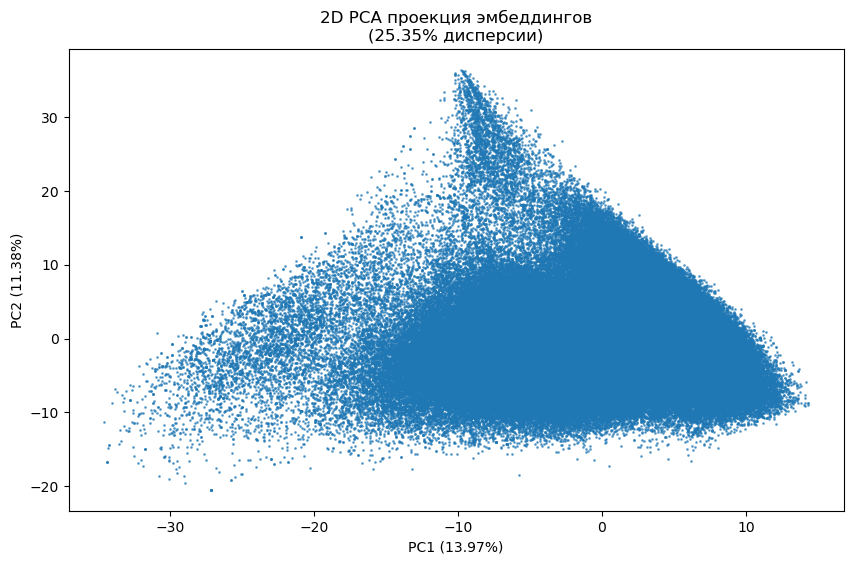

In [39]:
# 2D визуализация для понимания структуры
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

print(f"Дисперсия в 2D PCA: {pca_2d.explained_variance_ratio_.sum():.3%}")
print(f"PC1: {pca_2d.explained_variance_ratio_[0]:.3%}")
print(f"PC2: {pca_2d.explained_variance_ratio_[1]:.3%}")
print(f"Рекомендуемое количество компонент: {n_components_95}")
print("Низкая сложность ML задачи - можно использовать линейные модели (effective_dims < 50)")

plt.figure(figsize=(10, 6))
plt.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], alpha=0.6, s=1)
plt.title(f'2D PCA проекция эмбеддингов\n({pca_2d.explained_variance_ratio_.sum():.2%} дисперсии)')
plt.xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.2%})')
plt.ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.2%})')
plt.show()

Среднее: 1.9295 ± 0.0986
Медиана: 1.9119
Минимум: 1.2605
Максимум: 6.1126
Все молекулы в одной сфере, нет выбросов
Процентили норм:
  25%: 1.8819
  50%: 1.9119
  75%: 1.9502
  90%: 1.9989
  95%: 2.0498
  99%: 2.3462


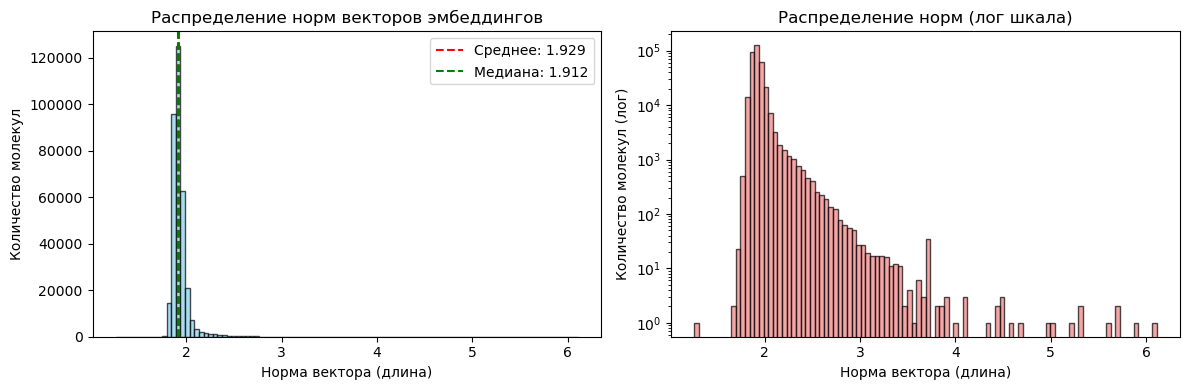

In [40]:
# Анализ норм векторов
norms = np.linalg.norm(X_embeddings, axis=1)
print(f"Среднее: {norms.mean():.4f} ± {norms.std():.4f}")
print(f"Медиана: {np.median(norms):.4f}")
print(f"Минимум: {norms.min():.4f}")
print(f"Максимум: {norms.max():.4f}")
print("Все молекулы в одной сфере, нет выбросов")

# Проверяем распределение норм
percentiles = [25, 50, 75, 90, 95, 99]
print("Процентили норм:")
for p in percentiles:
    print(f"  {p}%: {np.percentile(norms, p):.4f}")

# Визуализация распределения норм
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(norms, bins=100, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(norms.mean(), color='red', linestyle='--', label=f'Среднее: {norms.mean():.3f}')
plt.axvline(np.median(norms), color='green', linestyle='--', label=f'Медиана: {np.median(norms):.3f}')
plt.xlabel('Норма вектора (длина)')
plt.ylabel('Количество молекул')
plt.title('Распределение норм векторов эмбеддингов')
plt.legend()

plt.subplot(1, 2, 2)
# Логарифмическая шкала для лучшего обзора
plt.hist(norms, bins=100, alpha=0.7, color='lightcoral', edgecolor='black', log=True)
plt.xlabel('Норма вектора (длина)')
plt.ylabel('Количество молекул (лог)')
plt.title('Распределение норм (лог шкала)')

plt.tight_layout()
plt.show()

Среднее косинусное сходство: 0.0018
Медиана: -0.0134
Практически ноль, значит большинство молекул в эмбеддинговом пространстве почти ортогональны друг другу, эмбеддинги различимы
Минимум: -0.7219
Есть пары молекул с сильно противоположными векторами, модель может легко их различать
Максимум: 0.9973
Есть почти идентичные эмбеддинги, может указывать на дубликатные молекулы, которые могут слипаться в модели. Их стоит почистить в датасете!!


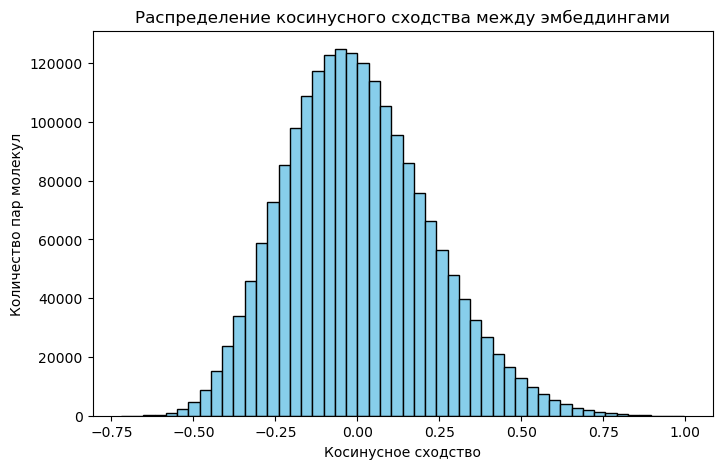

In [41]:
from sklearn.metrics.pairwise import cosine_similarity

# Проверим косинусное сходство между эмбеддингами
# Выбираем случайную подвыборку
sample_size = 2000
sample_idx = np.random.choice(X_scaled.shape[0], sample_size, replace=False)
sample_emb = X_scaled[sample_idx]
cos_sim = cosine_similarity(sample_emb)
cos_sim_flat = cos_sim[np.triu_indices_from(cos_sim, k=1)]

# Основные статистики
print(f"Среднее косинусное сходство: {cos_sim_flat.mean():.4f}")
print(f"Медиана: {np.median(cos_sim_flat):.4f}")
print('Практически ноль, значит большинство молекул в эмбеддинговом пространстве почти ортогональны друг другу, эмбеддинги различимы')
print(f"Минимум: {cos_sim_flat.min():.4f}")
print('Есть пары молекул с сильно противоположными векторами, модель может легко их различать')
print(f"Максимум: {cos_sim_flat.max():.4f}")
print('Есть почти идентичные эмбеддинги, может указывать на дубликатные молекулы, которые могут слипаться в модели. Их стоит почистить в датасете!!')
cos_sim_df = pd.DataFrame(cos_sim_flat, columns=["cosine_similarity"])
# Визуализация 
plt.figure(figsize=(8,5))
plt.hist(cos_sim_flat, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Косинусное сходство')
plt.ylabel('Количество пар молекул')
plt.title('Распределение косинусного сходства между эмбеддингами')
plt.show()


In [42]:
# Проверяем дубликаты по эмбеддингам
duplicated_idx = emb_df.duplicated(subset=embedding_cols, keep=False)
# Сколько молекул имеют дубликаты
num_duplicated = duplicated_idx.sum()
print(f"Количество молекул с дублирующимися эмбеддингами: {num_duplicated}")

Количество молекул с дублирующимися эмбеддингами: 10618
